In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# load the data
df = pd.read_csv("https://raw.githubusercontent.com/undertow515/123123/refs/heads/main/soyanggang_dam.csv")
df.dropna(inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

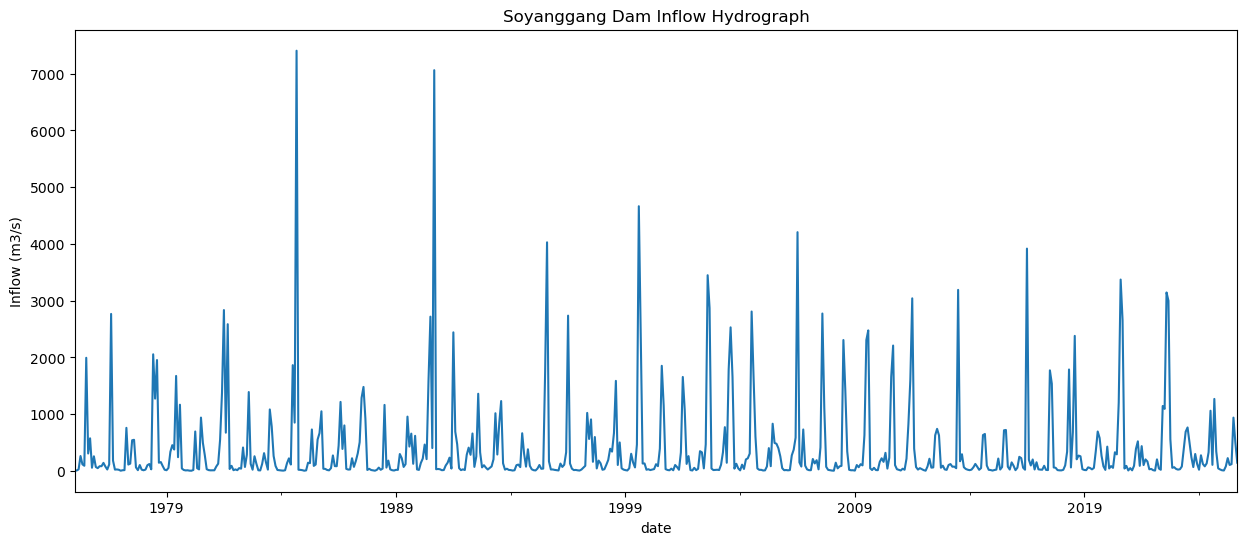

In [129]:
# Okay in this time, we learn the FFA (Flow Frequency Analysis) and FDC (Flow Duration Curve)
# First, let's plot the hydrograph
df["inflow_max"].plot(figsize=(15, 6), title="Soyanggang Dam Inflow Hydrograph", ylabel="Inflow (m3/s)")
plt.show()


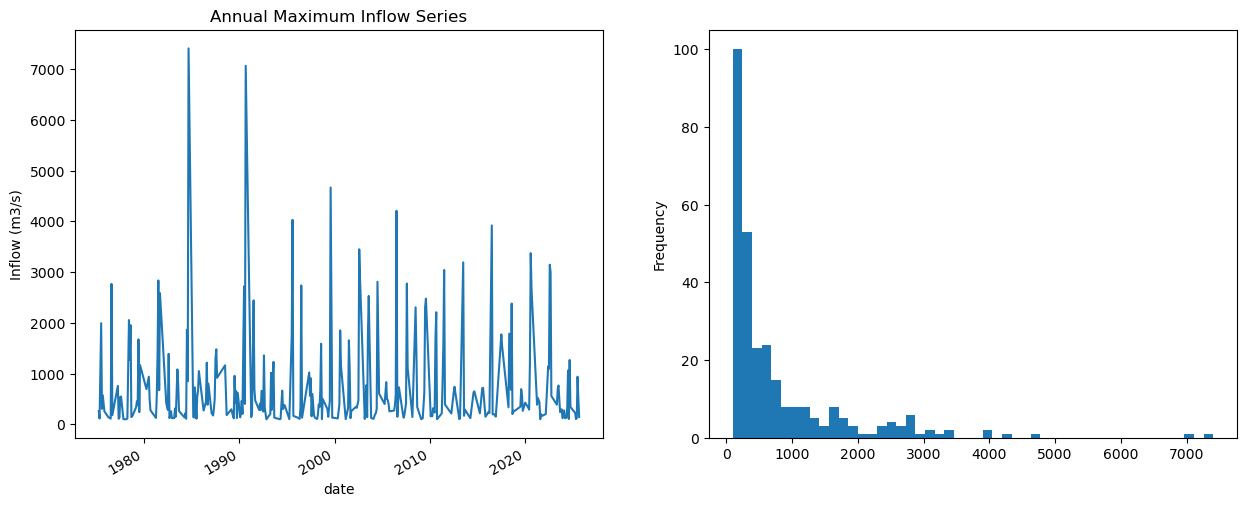

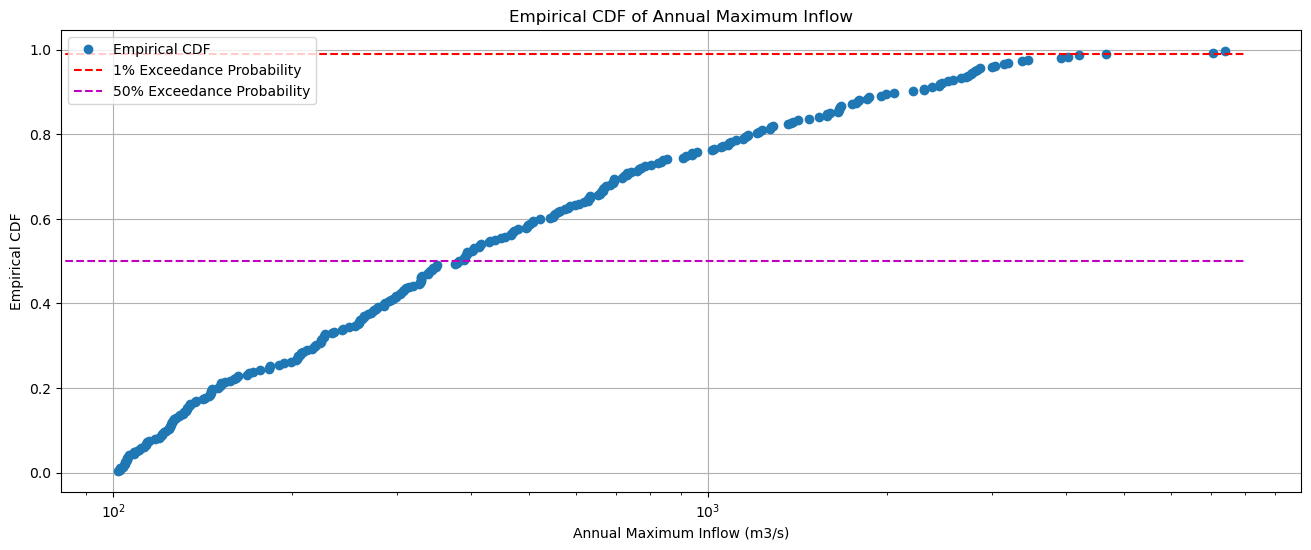

In [132]:
# for flood frequency analysis, we need to extract the annual maximum series (data available 1975-2025.09)
df_annual_max = df[df["inflow_max"] > 100]["inflow_max"]
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
df_annual_max.plot(ax=ax[0], title="Annual Maximum Inflow Series", ylabel="Inflow (m3/s)")
df_annual_max.plot(kind='hist', ax=ax[1],  bins=50)
plt.show()
# and we can plot the ecdf of the annual maximum series

# sort the data
data = np.sort(df_annual_max.values)
n = len(data)
# calculate the empirical CDF values
# P = M / (N + 1)  # M: rank, N: total number of data points

# okay what's 100-year return period value? (1% exceedance probability)
# 50-year (1/50 = 0.02)
# 30-year (1/30 = 0.0333)
# 2-year? (1/2 = 0.5)
P = np.arange(1, n + 1) / (n + 1)
plt.figure(figsize=(16, 6))
plt.plot(data, P, marker='o', linestyle='none', label='Empirical CDF')
plt.hlines(0.99, xmin=0, xmax=8000, colors='r', linestyles='dashed', label='1% Exceedance Probability')
# plt.hlines(1 - 1/50, xmin=0, xmax=8000, colors='g', linestyles='dashed', label='2% Exceedance Probability')
# plt.hlines(1 - 1/30, xmin=0, xmax=8000, colors='b', linestyles='dashed', label='3.33% Exceedance Probability')
plt.hlines(1 - 1/2, xmin=0, xmax=8000, colors='m', linestyles='dashed', label='50% Exceedance Probability')
plt.xscale('log')
plt.title('Empirical CDF of Annual Maximum Inflow')
plt.xlabel('Annual Maximum Inflow (m3/s)')
plt.ylabel('Empirical CDF')
plt.legend()
plt.grid()
plt.show()




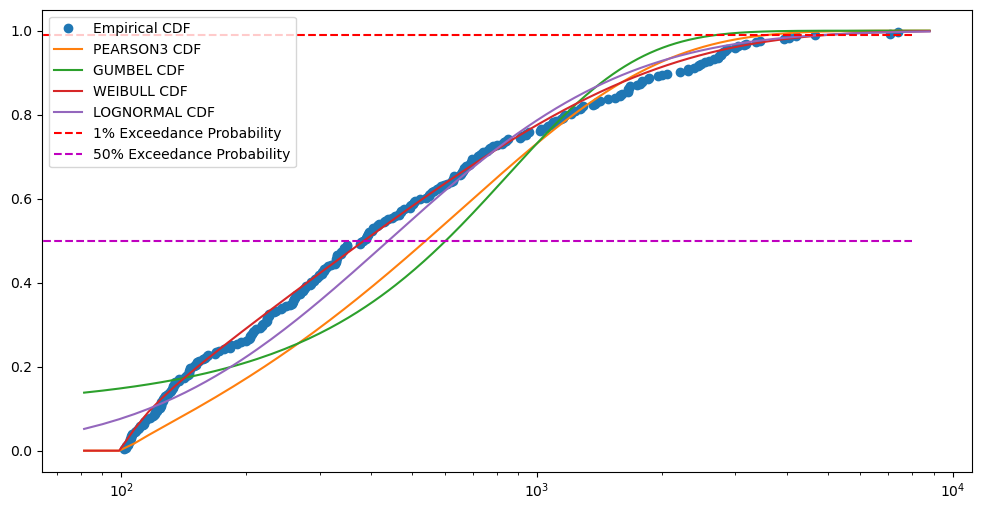

In [133]:
# okay and we now fit the logpearson type III distribution, gev, gumbel, weibull, lognormal
from scipy.stats import pearson3, genextreme, gumbel_r, weibull_min, lognorm

dist_dict = {
    'pearson3': pearson3,
    'gumbel': gumbel_r,
    'weibull': weibull_min,
    'lognormal': lognorm
}

params_dict = {}
for name, dist in dist_dict.items():
    if name == 'lognormal':
        shape, loc, scale = dist.fit(data, floc=0)  # fix loc to 0 for lognormal
        params_dict[name] = (shape, loc, scale)
    else:
        params = dist.fit(data)
        params_dict[name] = params

# let's see the diffrences between the distributions
# draw the empirical cdf and the fitted distributions

plt.figure(figsize=(12, 6))
plt.plot(data, P, marker='o', linestyle='none', label='Empirical CDF')
x = np.linspace(data.min() * 0.8, 8000*1.1, 1000)
for name, dist in dist_dict.items():
    params = params_dict[name]
    theoretical_cdf = dist.cdf(x, *params)
    plt.plot(x, theoretical_cdf, label=f'{name.upper()} CDF')
plt.hlines(0.99, xmin=0, xmax=8000, colors='r', linestyles='dashed', label='1% Exceedance Probability')
plt.hlines(1 - 1/2, xmin=0, xmax=8000, colors='m', linestyles='dashed', label='50% Exceedance Probability')
plt.xscale('log')
plt.legend()

# log_data = np.log10(data)
# shape, loc, scale = pearson3.fit(log_data)
# shape, loc, scale
# # calculate the theoretical CDF values
# theoretical_cdf = pearson3.cdf(log_data, shape, loc=loc, scale=scale)
# # plot the empirical and theoretical CDFs
# plt.figure(figsize=(16, 6))
# plt.plot(data, P, marker='o', linestyle='none', label='Empirical CDF')
# plt.plot(data, theoretical_cdf, label='Log-Pearson Type III CDF', color='orange')
# plt.hlines(0.99, xmin=0, xmax=8000, colors='r', linestyles='dashed', label='1% Exceedance Probability')
# plt.hlines(1 - 1/2, xmin=0, xmax=8000, colors='m', linestyles='dashed', label='50% Exceedance Probability')
# plt.xscale('log')
# plt.title('Empirical vs Theoretical CDF of Annual Maximum Inflow')
# plt.xlabel('Annual Maximum Inflow (m3/s)')
# plt.ylabel('CDF')
# plt.legend()
# plt.grid()
# plt.show()

In [134]:
aic_dict = {}
for name, dist in dist_dict.items():
    params = params_dict[name]
    if name == 'lognormal':
        shape, loc, scale = params
        log_likelihood = np.log(dist.pdf(data, shape, loc=loc, scale=scale)).sum()
    else:
        log_likelihood = np.log(dist.pdf(data, *params)).sum()
    k = len(params)
    aic = 2 * k - 2 * log_likelihood
    aic_dict[name] = aic

# print the AIC values
for name, aic in aic_dict.items():
    print(f'{name.upper()} AIC: {aic:.2f}')
# weibull seems fit the best ... 
print("*" * 30)
# print 100, 200 year return period values of the distributions

for name, dist in dist_dict.items():
    params = params_dict[name]
    if name == 'lognormal':
        shape, loc, scale = params
        rp_100 = dist.ppf(1 - 1/100, shape, loc=loc, scale=scale)
        rp_200 = dist.ppf(1 - 1/200, shape, loc=loc, scale=scale)
    else:
        rp_100 = dist.ppf(1 - 1/100, *params)
        rp_200 = dist.ppf(1 - 1/200, *params)
    print(f'{name.upper()} 100-year RP: {rp_100:.2f}, 200-year RP: {rp_200:.2f}')

PEARSON3 AIC: 4356.77
GUMBEL AIC: 4653.88
WEIBULL AIC: 4303.05
LOGNORMAL AIC: 4423.81
******************************
PEARSON3 100-year RP: 3590.38, 200-year RP: 4148.33
GUMBEL 100-year RP: 2710.98, 200-year RP: 3057.25
WEIBULL 100-year RP: 5017.39, 200-year RP: 6175.69
LOGNORMAL 100-year RP: 4885.08, 200-year RP: 6324.97


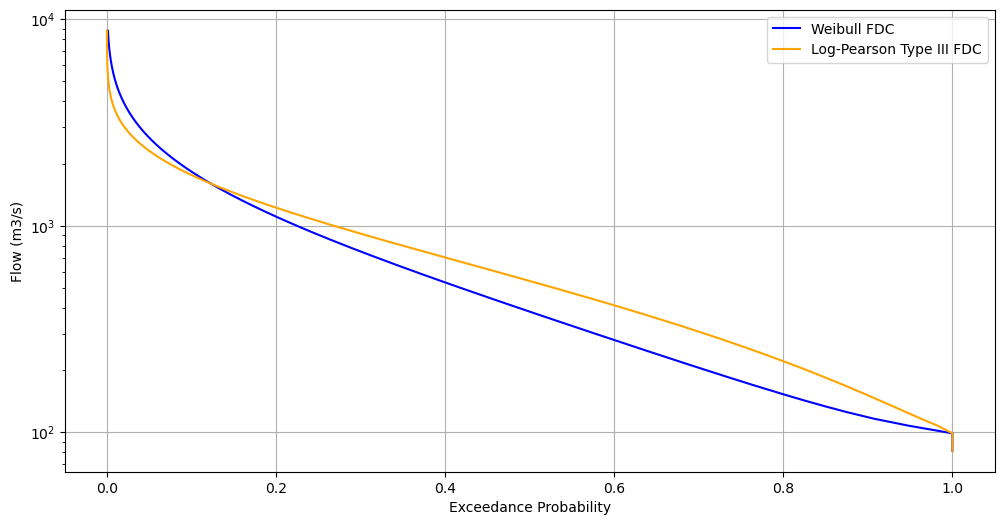

In [135]:
# lets plot the FDC (flow duration curve) of weibull distribution
weibull_params = params_dict['weibull']
shape, loc, scale = weibull_params
weibull_cdf = weibull_min.cdf(x, shape, loc=loc, scale=scale)
weibull_fdc = 1 - weibull_cdf

pearson3_params = params_dict['pearson3']
shape, loc, scale = pearson3_params
pearson3_cdf = pearson3.cdf(x, shape, loc=loc, scale=scale)
pearson3_fdc = 1 - pearson3_cdf


plt.figure(figsize=(12, 6))
plt.plot(weibull_fdc, x, label='Weibull FDC', color='blue')
plt.plot(pearson3_fdc, x, label='Log-Pearson Type III FDC', color='orange')
plt.xlabel('Exceedance Probability')
plt.ylabel('Flow (m3/s)')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [136]:
# 100-year return period flow
shape, loc, scale = weibull_params
weibull_ppf_100 = weibull_min.ppf(1 - 1/100, shape, loc=loc, scale=scale)
# 200-year return period flow
weibull_ppf_200 = weibull_min.ppf(1 - 1/200, shape, loc=loc, scale=scale)
print(f"100-year return period flow (Weibull): {weibull_ppf_100:.2f} m3/s")
print(f"200-year return period flow (Weibull): {weibull_ppf_200:.2f} m3/s")

# 100-year return period flow of empirical data
empirical_100yr = np.percentile(data, 99)
print(f"100-year return period flow (Empirical): {empirical_100yr:.2f} m3/s")
empirical_200yr = np.percentile(data, 99.5)
print(f"200-year return period flow (Empirical): {empirical_200yr:.2f} m3/s")


# see the deferences?

100-year return period flow (Weibull): 5017.39 m3/s
200-year return period flow (Weibull): 6175.69 m3/s
100-year return period flow (Empirical): 4244.74 m3/s
200-year return period flow (Empirical): 5959.84 m3/s


In [137]:
# okay ... lets calculate the confidence interval of the 100-year return period flow (alpha = 0.1)

import scipy.stats as stats
alpha = 0.1
n = len(data)
# for weibull distribution
shape, loc, scale = weibull_params
weibull_ppf_100 = weibull_min.ppf(1 - 1/100, shape, loc=loc, scale=scale)
# standard error using delta method
# delta method is assuming the variance of the estimator is small enough to approximate the distribution of the estimator by a normal distribution
# se = (dF/dx) * (1/n) * (F(1-F))  # F is the cdf value at the return period
se_weibull_100 = (scale * (1/shape) * ((-np.log(1 - 1/100))**(1/shape - 1)) * (1/(n * (1 - 1/100)))) # this is the standard error of the 100-year return period flow
ci_weibull_100 = stats.norm.ppf(1 - alpha/2) * se_weibull_100
print(f"Weibull 100-year return period flow: {weibull_ppf_100:.2f} m3/s, 90% CI: ({weibull_ppf_100 - ci_weibull_100:.2f}, {weibull_ppf_100 + ci_weibull_100:.2f})")

Weibull 100-year return period flow: 5017.39 m3/s, 90% CI: (5016.98, 5017.79)


Parametric Confidence Intervals (90%):
  2-year RP:    384 m³/s, 90% CI: [   331,    437]
  5-year RP:   1108 m³/s, 90% CI: [  1075,   1141]
 10-year RP:   1829 m³/s, 90% CI: [  1803,   1854]
 20-year RP:   2671 m³/s, 90% CI: [  2651,   2690]
 30-year RP:   3213 m³/s, 90% CI: [  3196,   3230]
 50-year RP:   3945 m³/s, 90% CI: [  3931,   3959]
100-year RP:   5017 m³/s, 90% CI: [  5007,   5028]
200-year RP:   6176 m³/s, 90% CI: [  6168,   6184]


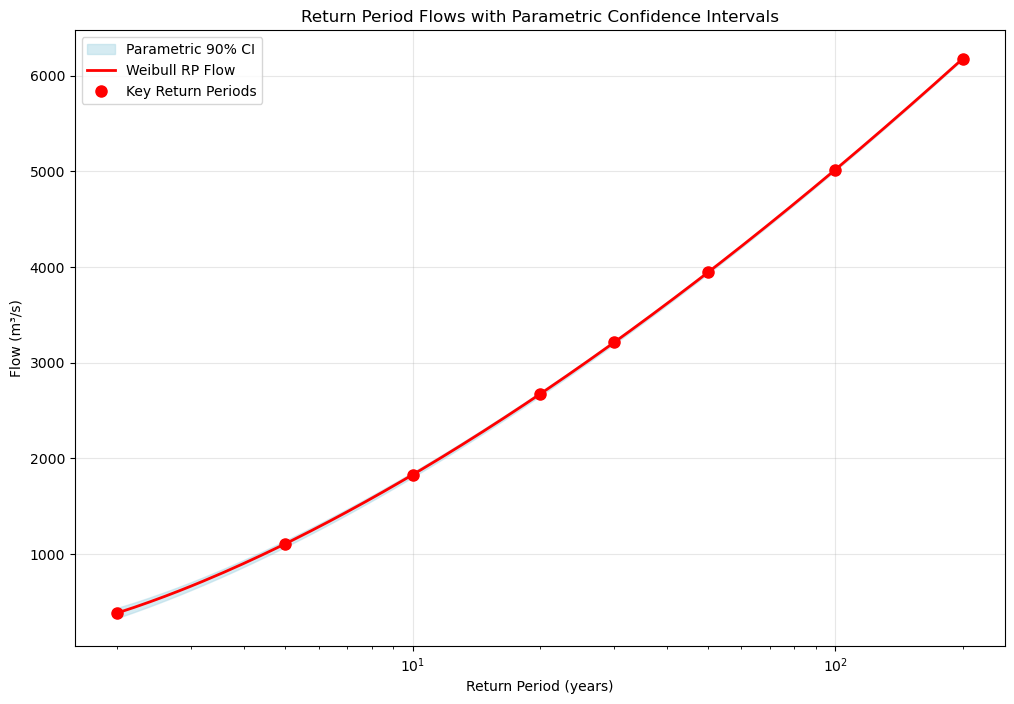

In [138]:
# yes extending of this code, we can calculate the confidence interval of the [2,5,10,20,30,50,100,200] year return period flows
# This is the parametric approach using delta method (more theoretically sound)

def calculate_return_period_ci_parametric(dist, params, return_period, n, alpha=0.1):
    """
    Calculate confidence interval using parametric approach (delta method)
    This is the standard method used in hydrology
    """
    shape, loc, scale = params
    rp_flow = dist.ppf(1 - 1/return_period, shape, loc=loc, scale=scale)
    
    # For Weibull distribution, use asymptotic variance
    # This is a simplified version - more complex formulas exist in literature
    p = 1 - 1/return_period
    
    # Approximate standard error using Fisher Information Matrix approach
    # This is a simplified approximation
    variance_approx = (rp_flow ** 2) * (1.0 / n) * ((1 - p) / (p * (np.log(1 - p)) ** 2))
    se = np.sqrt(variance_approx)
    
    z_alpha = stats.norm.ppf(1 - alpha/2)
    ci_lower = rp_flow - z_alpha * se
    ci_upper = rp_flow + z_alpha * se
    
    return rp_flow, (ci_lower, ci_upper)

# Plot parametric confidence intervals
plt.figure(figsize=(12, 8))

# Calculate for specific return periods first
return_periods_specific = [2, 5, 10, 20, 30, 50, 100, 200]
rp_flows_specific = []
ci_lower_specific = []
ci_upper_specific = []

print("Parametric Confidence Intervals (90%):")
for rp in return_periods_specific:
    rp_flow, ci = calculate_return_period_ci_parametric(weibull_min, weibull_params, rp, n, alpha=0.1)
    rp_flows_specific.append(rp_flow)
    ci_lower_specific.append(ci[0])
    ci_upper_specific.append(ci[1])
    print(f"{rp:3d}-year RP: {rp_flow:6.0f} m³/s, 90% CI: [{ci[0]:6.0f}, {ci[1]:6.0f}]")

# Plot for continuous range
x = np.linspace(2, 200, 1000)
rpfs = []
ci_lower_continuous = []
ci_upper_continuous = []

for rp in x:
    rp_flow, ci = calculate_return_period_ci_parametric(weibull_min, weibull_params, rp, n, alpha=0.1)
    rpfs.append(rp_flow)
    ci_lower_continuous.append(ci[0])
    ci_upper_continuous.append(ci[1])

plt.fill_between(x, ci_lower_continuous, ci_upper_continuous, color='lightblue', alpha=0.5, label='Parametric 90% CI')
plt.plot(x, rpfs, color='red', linewidth=2, label='Weibull RP Flow')
plt.plot(return_periods_specific, rp_flows_specific, 'ro', markersize=8, label='Key Return Periods')

plt.xlabel('Return Period (years)')
plt.ylabel('Flow (m³/s)')
plt.title('Return Period Flows with Parametric Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.show()



Starting bootstrap sampling...
Bootstrap iteration 100/1000
Bootstrap iteration 100/1000
Bootstrap iteration 200/1000
Bootstrap iteration 200/1000
Bootstrap iteration 300/1000
Bootstrap iteration 300/1000
Bootstrap iteration 400/1000
Bootstrap iteration 400/1000
Bootstrap iteration 500/1000
Bootstrap iteration 500/1000
Bootstrap iteration 600/1000
Bootstrap iteration 600/1000
Bootstrap iteration 700/1000
Bootstrap iteration 700/1000
Bootstrap iteration 800/1000
Bootstrap iteration 800/1000
Bootstrap iteration 900/1000
Bootstrap iteration 900/1000
Bootstrap iteration 1000/1000
Bootstrap iteration 1000/1000
2-year RP: 384 m³/s, 90% CI: [347, 660]
5-year RP: 1108 m³/s, 90% CI: [952, 2129]
10-year RP: 1829 m³/s, 90% CI: [1501, 3646]
20-year RP: 2671 m³/s, 90% CI: [2119, 5441]
30-year RP: 3213 m³/s, 90% CI: [2494, 6666]
50-year RP: 3945 m³/s, 90% CI: [2980, 8347]
100-year RP: 5017 m³/s, 90% CI: [3675, 10826]
200-year RP: 6176 m³/s, 90% CI: [4403, 13438]
2-year RP: 384 m³/s, 90% CI: [347, 66

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41420\2022270809.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(return_periods, original_rpfs, 'ro-', color='red', linewidth=2, label='Weibull RP Flow (Original)')


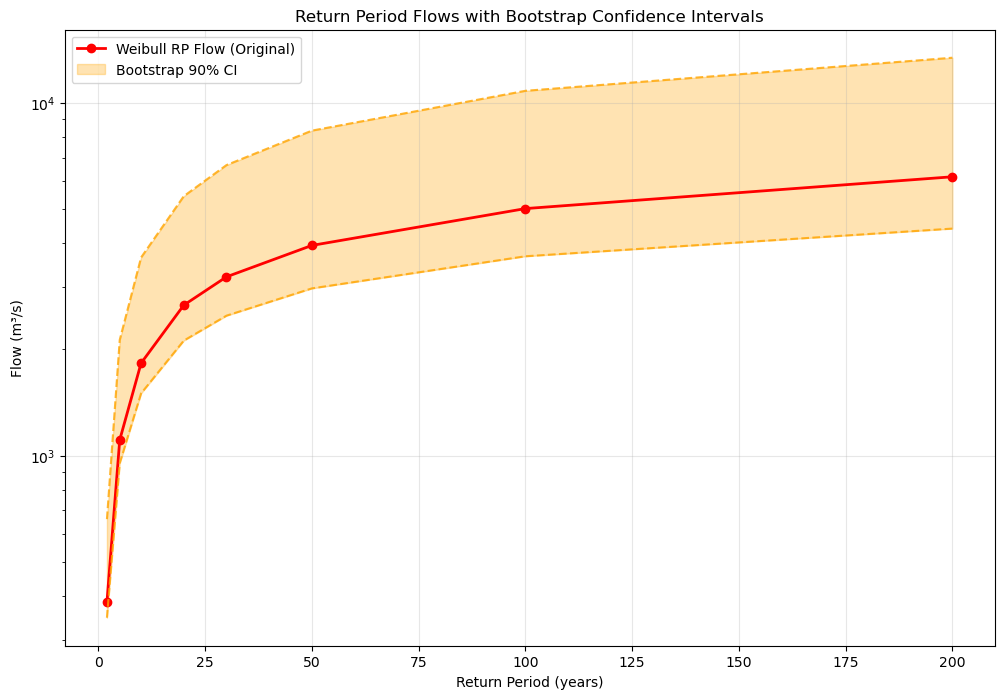

In [139]:
# or, we can calculate the confidence interval using bootstrap method
n_bootstrap = 1000
return_periods = [2, 5, 10, 20, 30, 50, 100, 200]
bootstrap_results = {rp: [] for rp in return_periods}

print("Starting bootstrap sampling...")
for i in range(n_bootstrap):
    if (i + 1) % 100 == 0:
        print(f"Bootstrap iteration {i + 1}/{n_bootstrap}")
    
    # Create bootstrap sample (same size as original data)
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    
    # Fit Weibull distribution to bootstrap sample
    try:
        bootstrap_params = weibull_min.fit(bootstrap_sample)
        
        # Calculate return period flows for this bootstrap sample
        for rp in return_periods:
            rp_flow = weibull_min.ppf(1 - 1/rp, *bootstrap_params)
            bootstrap_results[rp].append(rp_flow)
    except:
        # Skip this iteration if fitting fails
        continue

# Calculate confidence intervals and plot
plt.figure(figsize=(12, 8))

# Plot original fitted line
original_rpfs = []
for rp in return_periods:
    original_rp_flow = weibull_min.ppf(1 - 1/rp, *weibull_params)
    original_rpfs.append(original_rp_flow)

plt.plot(return_periods, original_rpfs, 'ro-', color='red', linewidth=2, label='Weibull RP Flow (Original)')

# Calculate and plot bootstrap confidence intervals
lower_ci = []
upper_ci = []
for rp in return_periods:
    if len(bootstrap_results[rp]) > 0:
        lower = np.percentile(bootstrap_results[rp], 5)  # 5th percentile for 90% CI
        upper = np.percentile(bootstrap_results[rp], 95) # 95th percentile for 90% CI
        lower_ci.append(lower)
        upper_ci.append(upper)
        print(f"{rp}-year RP: {weibull_min.ppf(1 - 1/rp, *weibull_params):.0f} m³/s, "
              f"90% CI: [{lower:.0f}, {upper:.0f}]")
    else:
        lower_ci.append(np.nan)
        upper_ci.append(np.nan)

plt.fill_between(return_periods, lower_ci, upper_ci, color='orange', alpha=0.3, label='Bootstrap 90% CI')
plt.plot(return_periods, lower_ci, '--', color='orange', alpha=0.8)
plt.plot(return_periods, upper_ci, '--', color='orange', alpha=0.8)

plt.xlabel('Return Period (years)')
plt.ylabel('Flow (m³/s)')
plt.title('Return Period Flows with Bootstrap Confidence Intervals')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.show()


# Comprehensive Uncertainty Analysis in Flood Frequency Analysis

We will analyze four main sources of uncertainty:

1. **Model Selection Uncertainty**: Different probability distributions (Weibull, Gumbel, Pearson Type III, Lognormal)
2. **Sample Size Uncertainty**: Impact of data length on estimates
3. **Statistical Method Uncertainty**: Parametric vs Bootstrap approaches
4. **Total Uncertainty**: Combined effect of all uncertainty sources

This analysis is crucial for robust flood risk assessment and infrastructure design.

1. Distribution Selection Uncertainty
WEIBULL   :   5017 m³/s
GUMBEL    :   2711 m³/s
PEARSON3  :   3590 m³/s
LOGNORMAL :   4885 m³/s

Uncertainty Statistics:
Mean: 4051 m³/s
Std Dev: 954 m³/s
CV: 23.5%
Range: 2306 m³/s


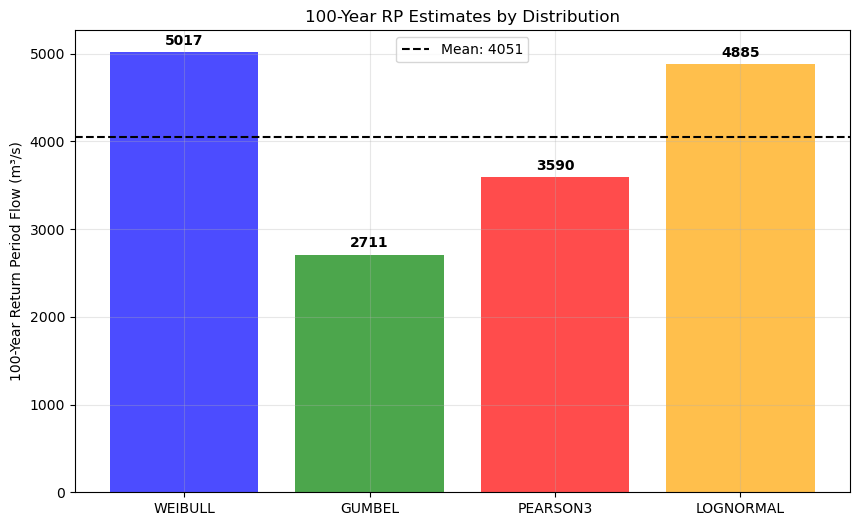

In [140]:
# 1. MODEL SELECTION UNCERTAINTY
print("1. Distribution Selection Uncertainty")

# Compare distributions
from scipy.stats import genextreme
dists = {'weibull': weibull_min, 'gumbel': gumbel_r, 'pearson3': pearson3, 'lognormal': lognorm}

# Calculate 100-year return period values
rp_100_values = []
dist_names = []

for name, dist in dists.items():
    try:
        if name == 'lognormal':
            params = dist.fit(data, floc=0)
        else:
            params = dist.fit(data)
        
        rp_100 = dist.ppf(1 - 1/100, *params)
        rp_100_values.append(rp_100)
        dist_names.append(name.upper())
        print(f"{name.upper():10s}: {rp_100:6.0f} m³/s")
    except:
        continue

# Quantify uncertainty
mean_val = np.mean(rp_100_values)
std_val = np.std(rp_100_values)
cv = std_val / mean_val * 100
range_val = max(rp_100_values) - min(rp_100_values)

print(f"\nUncertainty Statistics:")
print(f"Mean: {mean_val:.0f} m³/s")
print(f"Std Dev: {std_val:.0f} m³/s")
print(f"CV: {cv:.1f}%")
print(f"Range: {range_val:.0f} m³/s")

# Simple plot
plt.figure(figsize=(10, 6))
bars = plt.bar(dist_names, rp_100_values, color=['blue', 'green', 'red', 'orange'][:len(dist_names)], alpha=0.7)
plt.axhline(y=mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.0f}')
plt.ylabel('100-Year Return Period Flow (m³/s)')
plt.title('100-Year RP Estimates by Distribution')
plt.grid(True, alpha=0.3)
plt.legend()

# Add values on bars
for bar, value in zip(bars, rp_100_values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.show()

2. Sample Size Effect on Uncertainty
Size 29: Mean= 6322, Std=3007, CV=47.6%
Size 29: Mean= 6322, Std=3007, CV=47.6%
Size 58: Mean= 6521, Std=2872, CV=44.1%
Size 58: Mean= 6521, Std=2872, CV=44.1%
Size 87: Mean= 6400, Std=2645, CV=41.3%
Size 87: Mean= 6400, Std=2645, CV=41.3%
Size 117: Mean= 6800, Std=2478, CV=36.4%
Size 117: Mean= 6800, Std=2478, CV=36.4%
Size 146: Mean= 5787, Std=1905, CV=32.9%
Size 146: Mean= 5787, Std=1905, CV=32.9%
Size 175: Mean= 5567, Std=1826, CV=32.8%
Size 175: Mean= 5567, Std=1826, CV=32.8%
Size 205: Mean= 5478, Std=1447, CV=26.4%
Size 205: Mean= 5478, Std=1447, CV=26.4%
Size 234: Mean= 5509, Std=1412, CV=25.6%
Size 234: Mean= 5509, Std=1412, CV=25.6%
Size 263: Mean= 5640, Std=1635, CV=29.0%
Size 293: Mean= 5017, Std=   0, CV= 0.0%
Size 263: Mean= 5640, Std=1635, CV=29.0%
Size 293: Mean= 5017, Std=   0, CV= 0.0%


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41420\1288750751.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = ax1.boxplot(box_data, labels=sample_sizes, patch_artist=True)


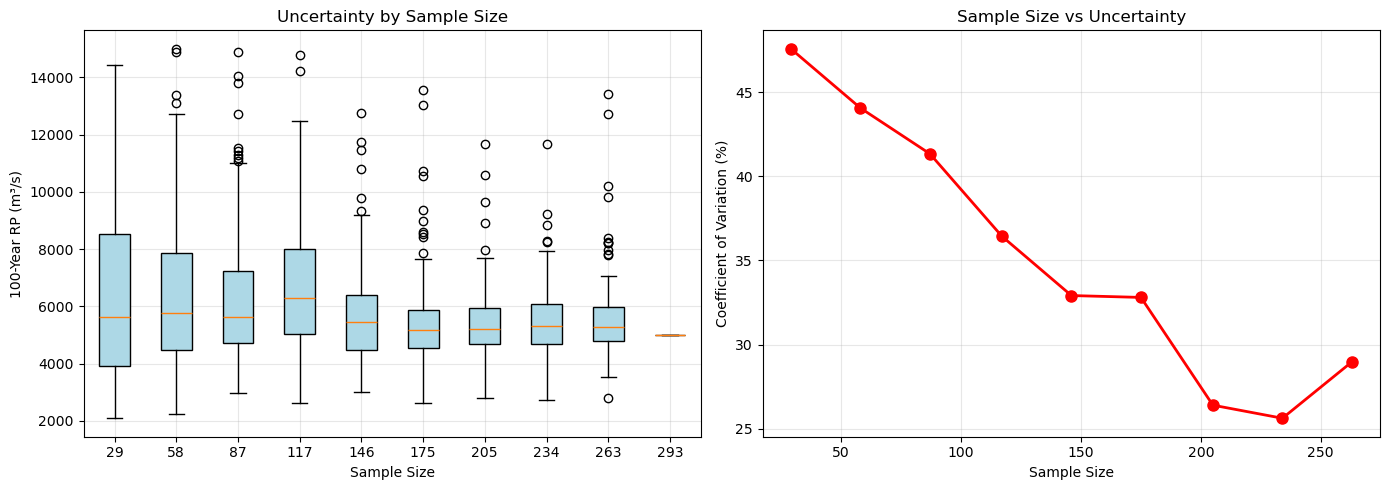

In [ ]:
# 2. SAMPLE SIZE UNCERTAINTY
print("2. Sample Size Effect on Uncertainty")

# Test various sample sizes
sample_sizes = [int(len(data) * frac) for frac in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]
n_iter = 100

results = {}
for size in sample_sizes:
    rp_100_list = []
    
    if size >= len(data):
        # Use full dataset
        rp_100_list = [weibull_min.ppf(1 - 1/100, *weibull_params)]
    else:
        # Sub-sampling
        for i in range(n_iter):
            try:
                subsample = np.random.choice(data, size=size, replace=False)
                params = weibull_min.fit(subsample)
                rp_100 = weibull_min.ppf(1 - 1/100, *params)
                
                if 2000 < rp_100 < 15000:  # Remove outliers
                    rp_100_list.append(rp_100)
            except:
                continue
    
    results[size] = rp_100_list
    
    if len(rp_100_list) > 0:
        mean_val = np.mean(rp_100_list)
        std_val = np.std(rp_100_list)
        cv = std_val / mean_val * 100
        print(f"Size {size:2d}: Mean={mean_val:5.0f}, Std={std_val:4.0f}, CV={cv:4.1f}%")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
box_data = [results[sz] for sz in sample_sizes]
box1 = ax1.boxplot(box_data, labels=sample_sizes, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor('lightblue')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('100-Year RP (m³/s)')
ax1.set_title('Uncertainty by Sample Size')
ax1.grid(True, alpha=0.3)

# CV plot
ax2 = axes[1]
cv_values = []
sizes_plot = []

for sz in sample_sizes:
    if len(results[sz]) > 1:
        mean_val = np.mean(results[sz])
        std_val = np.std(results[sz])
        cv = std_val / mean_val * 100
        cv_values.append(cv)
        sizes_plot.append(sz)

ax2.plot(sizes_plot, cv_values, 'o-', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Coefficient of Variation (%)')
ax2.set_title('Sample Size vs Uncertainty')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. STATISTICAL METHOD UNCERTAINTY ANALYSIS
Computing parametric confidence intervals...
Computing bootstrap confidence intervals...
  Bootstrap iteration 200/2000
  Bootstrap iteration 200/2000
  Bootstrap iteration 400/2000
  Bootstrap iteration 400/2000
  Bootstrap iteration 600/2000
  Bootstrap iteration 600/2000
  Bootstrap iteration 800/2000
  Bootstrap iteration 800/2000
  Bootstrap iteration 1000/2000
  Bootstrap iteration 1000/2000
  Bootstrap iteration 1200/2000
  Bootstrap iteration 1200/2000
  Bootstrap iteration 1400/2000
  Bootstrap iteration 1400/2000
  Bootstrap iteration 1600/2000
  Bootstrap iteration 1600/2000
  Bootstrap iteration 1800/2000
  Bootstrap iteration 1800/2000
  Bootstrap iteration 2000/2000
  Bootstrap iteration 2000/2000


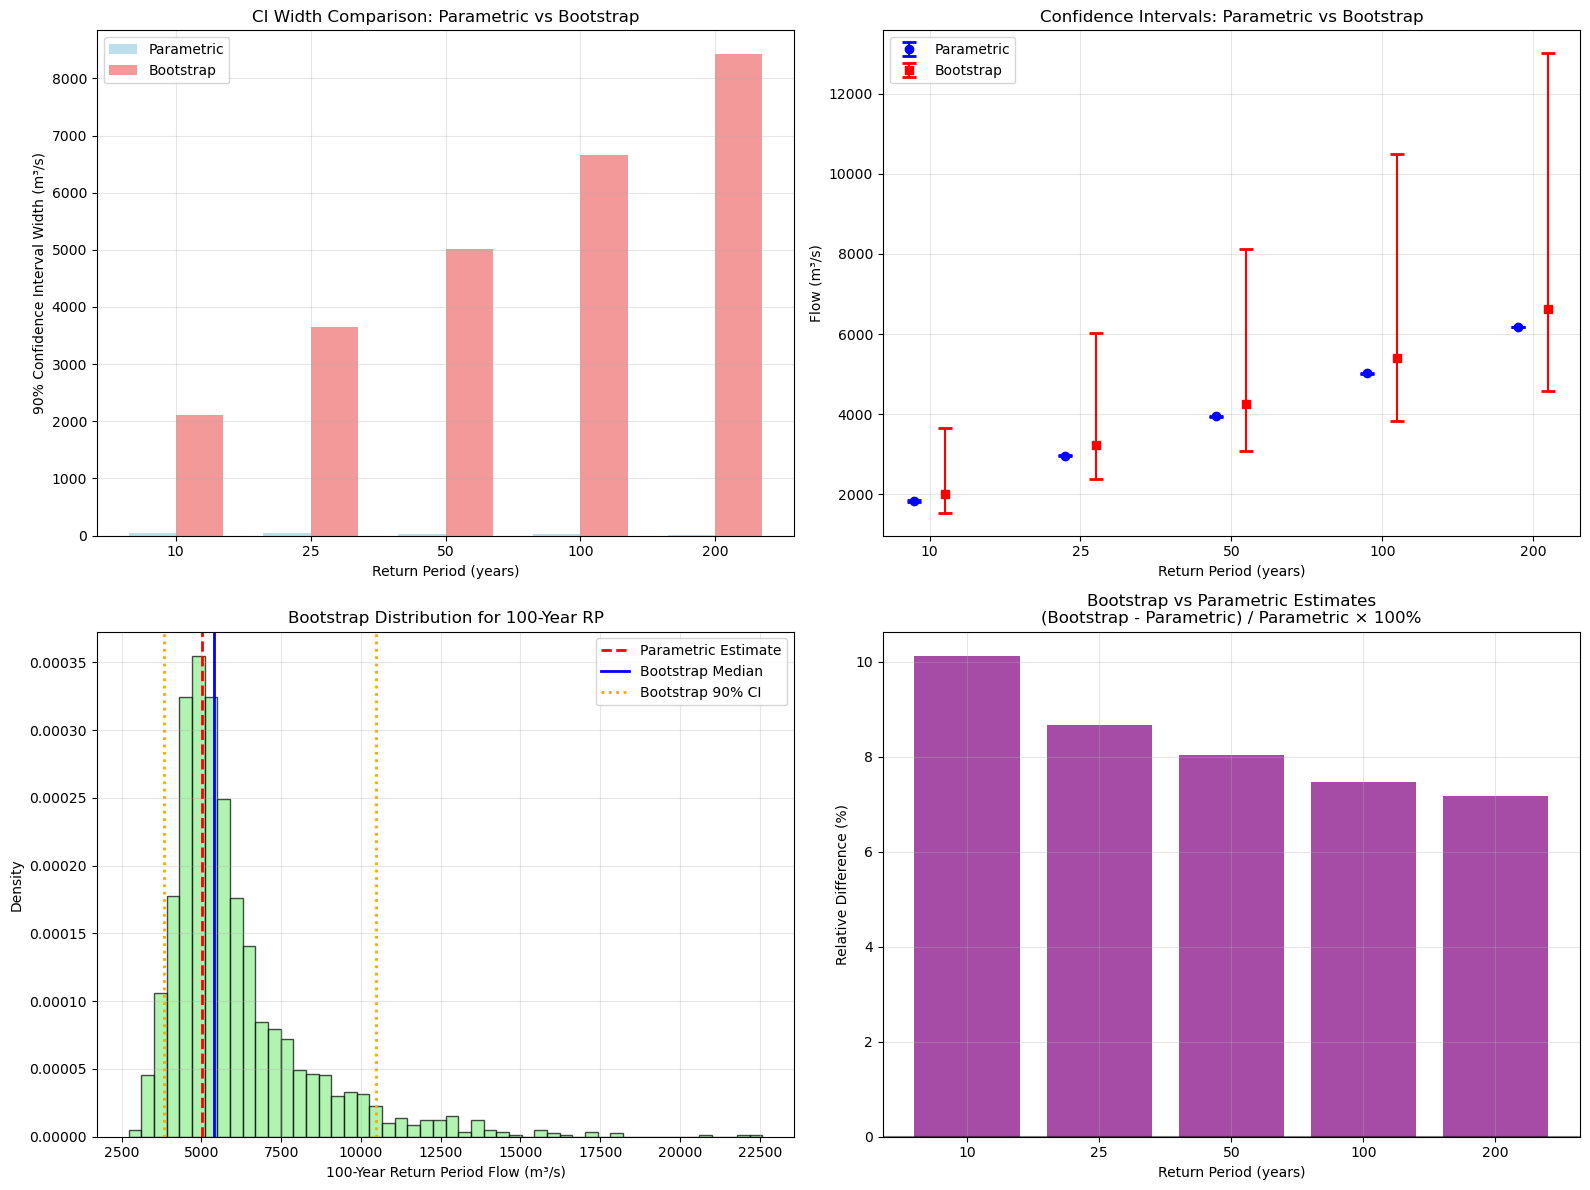


STATISTICAL METHOD UNCERTAINTY COMPARISON
RP(yr) | Parametric Est±CI Width | Bootstrap Est±CI Width | Relative Diff(%)
--------------------------------------------------------------------------------
  10   |   1829 ±   51        |   2014 ± 2116        |    +10.1
  25   |   2965 ±   36        |   3222 ± 3642        |     +8.7
  50   |   3945 ±   28        |   4262 ± 5018        |     +8.0
 100   |   5017 ±   21        |   5392 ± 6657        |     +7.5
 200   |   6176 ±   16        |   6619 ± 8420        |     +7.2

Note: Relative Difference = (Bootstrap - Parametric) / Parametric × 100%


In [142]:
# 3. STATISTICAL METHOD UNCERTAINTY
# Compare Parametric vs Bootstrap approaches

print("="*60)
print("3. STATISTICAL METHOD UNCERTAINTY ANALYSIS")
print("="*60)

# Parametric approach (already computed above)
parametric_results = {}
bootstrap_results_method = {}

return_periods_method = [10, 25, 50, 100, 200]

print("Computing parametric confidence intervals...")
for rp in return_periods_method:
    rp_flow, ci = calculate_return_period_ci_parametric(weibull_min, weibull_params, rp, n, alpha=0.1)
    parametric_results[rp] = {
        'estimate': rp_flow,
        'ci_lower': ci[0],
        'ci_upper': ci[1],
        'ci_width': ci[1] - ci[0]
    }

print("Computing bootstrap confidence intervals...")
n_bootstrap_method = 2000
bootstrap_samples_method = {rp: [] for rp in return_periods_method}

# Generate bootstrap samples
for i in range(n_bootstrap_method):
    if (i + 1) % 200 == 0:
        print(f"  Bootstrap iteration {i + 1}/{n_bootstrap_method}")
    
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    
    try:
        bootstrap_params = weibull_min.fit(bootstrap_sample)
        
        for rp in return_periods_method:
            rp_flow = weibull_min.ppf(1 - 1/rp, *bootstrap_params)
            if 500 < rp_flow < 25000:  # Remove extreme outliers
                bootstrap_samples_method[rp].append(rp_flow)
    except:
        continue

# Calculate bootstrap confidence intervals
for rp in return_periods_method:
    if len(bootstrap_samples_method[rp]) > 100:
        estimate = np.median(bootstrap_samples_method[rp])
        ci_lower = np.percentile(bootstrap_samples_method[rp], 5)
        ci_upper = np.percentile(bootstrap_samples_method[rp], 95)
        
        bootstrap_results_method[rp] = {
            'estimate': estimate,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower,
            'samples': bootstrap_samples_method[rp]
        }

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confidence interval comparison
ax1 = axes[0, 0]
rp_list = list(return_periods_method)
parametric_widths = [parametric_results[rp]['ci_width'] for rp in rp_list]
bootstrap_widths = [bootstrap_results_method[rp]['ci_width'] for rp in rp_list if rp in bootstrap_results_method]

x = np.arange(len(rp_list))
width = 0.35

ax1.bar(x - width/2, parametric_widths, width, label='Parametric', color='lightblue', alpha=0.8)
ax1.bar(x + width/2, bootstrap_widths, width, label='Bootstrap', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Return Period (years)')
ax1.set_ylabel('90% Confidence Interval Width (m³/s)')
ax1.set_title('CI Width Comparison: Parametric vs Bootstrap')
ax1.set_xticks(x)
ax1.set_xticklabels(rp_list)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confidence intervals visualization
ax2 = axes[0, 1]
for i, rp in enumerate(rp_list):
    if rp in bootstrap_results_method:
        # Parametric
        para_est = parametric_results[rp]['estimate']
        para_lower = parametric_results[rp]['ci_lower']
        para_upper = parametric_results[rp]['ci_upper']
        
        # Bootstrap
        boot_est = bootstrap_results_method[rp]['estimate']
        boot_lower = bootstrap_results_method[rp]['ci_lower']
        boot_upper = bootstrap_results_method[rp]['ci_upper']
        
        # Plot error bars
        ax2.errorbar(i - 0.1, para_est, yerr=[[para_est - para_lower], [para_upper - para_est]], 
                    fmt='o', color='blue', label='Parametric' if i == 0 else "", capsize=5, capthick=2)
        ax2.errorbar(i + 0.1, boot_est, yerr=[[boot_est - boot_lower], [boot_upper - boot_est]], 
                    fmt='s', color='red', label='Bootstrap' if i == 0 else "", capsize=5, capthick=2)

ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('Flow (m³/s)')
ax2.set_title('Confidence Intervals: Parametric vs Bootstrap')
ax2.set_xticks(range(len(rp_list)))
ax2.set_xticklabels(rp_list)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Bootstrap distribution histograms for 100-year RP
ax3 = axes[1, 0]
if 100 in bootstrap_results_method:
    samples_100 = bootstrap_results_method[100]['samples']
    ax3.hist(samples_100, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
    ax3.axvline(parametric_results[100]['estimate'], color='red', linestyle='--', linewidth=2, label='Parametric Estimate')
    ax3.axvline(bootstrap_results_method[100]['estimate'], color='blue', linestyle='-', linewidth=2, label='Bootstrap Median')
    ax3.axvline(bootstrap_results_method[100]['ci_lower'], color='orange', linestyle=':', linewidth=2, label='Bootstrap 90% CI')
    ax3.axvline(bootstrap_results_method[100]['ci_upper'], color='orange', linestyle=':', linewidth=2)
    
    ax3.set_xlabel('100-Year Return Period Flow (m³/s)')
    ax3.set_ylabel('Density')
    ax3.set_title('Bootstrap Distribution for 100-Year RP')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Method bias comparison
ax4 = axes[1, 1]
parametric_estimates = [parametric_results[rp]['estimate'] for rp in rp_list]
bootstrap_estimates = [bootstrap_results_method[rp]['estimate'] for rp in rp_list if rp in bootstrap_results_method]

# Calculate relative differences
relative_diff = [(b - p) / p * 100 for p, b in zip(parametric_estimates, bootstrap_estimates)]

ax4.bar(range(len(rp_list)), relative_diff, color='purple', alpha=0.7)
ax4.set_xlabel('Return Period (years)')
ax4.set_ylabel('Relative Difference (%)')
ax4.set_title('Bootstrap vs Parametric Estimates\n(Bootstrap - Parametric) / Parametric × 100%')
ax4.set_xticks(range(len(rp_list)))
ax4.set_xticklabels(rp_list)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*80}")
print("STATISTICAL METHOD UNCERTAINTY COMPARISON")
print(f"{'='*80}")
print("RP(yr) | Parametric Est±CI Width | Bootstrap Est±CI Width | Relative Diff(%)")
print("-" * 80)

for rp in rp_list:
    if rp in bootstrap_results_method:
        para_est = parametric_results[rp]['estimate']
        para_width = parametric_results[rp]['ci_width']
        boot_est = bootstrap_results_method[rp]['estimate']
        boot_width = bootstrap_results_method[rp]['ci_width']
        rel_diff = (boot_est - para_est) / para_est * 100
        
        print(f" {rp:3d}   | {para_est:6.0f} ± {para_width:4.0f}        | {boot_est:6.0f} ± {boot_width:4.0f}        |    {rel_diff:+5.1f}")

print(f"\nNote: Relative Difference = (Bootstrap - Parametric) / Parametric × 100%")

In [145]:
total_uncertainty = {}
for rp in rp_list:
    if rp in parametric_results and rp in bootstrap_results_method:
        # para_width = parametric_results[rp]['ci_width']
        boot_width = bootstrap_results_method[rp]['ci_width']
        total_uncertainty[rp] = boot_width
        print(f"Total Uncertainty for {rp}-year RP: {total_uncertainty[rp]:.0f} m³/s")


Total Uncertainty for 10-year RP: 2116 m³/s
Total Uncertainty for 25-year RP: 3642 m³/s
Total Uncertainty for 50-year RP: 5018 m³/s
Total Uncertainty for 100-year RP: 6657 m³/s
Total Uncertainty for 200-year RP: 8420 m³/s
